In [ ]:
! pip install google-play-scraper
! pip install -qq -U gensim
! pip install -qq pyLDAvis
! pip install -qq tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google_play_scraper import app
from google_play_scraper import Sort, reviews_all
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import preprocessor as prepro # text prepro
from sklearn.feature_extraction.text import CountVectorizer
import tqdm #progress bar
# topic modeling(Gensim)
from gensim.corpora.dictionary import Dictionary # Import the dictionary builder
from gensim.models import LdaMulticore # we'll use the faster multicore version of LDA
import gensim.corpora as corpora
import gensim, spacy, logging, warnings
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# Import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import nltk
import spacy #spacy for quick language prepro
nlp = spacy.load('en_core_web_sm') #instantiating English module

In [ ]:
reviews = reviews_all('dk.maternity.safedelivery')

In [ ]:
df = pd.DataFrame(np.array(reviews),columns=['review'])
df = df.join(pd.DataFrame(df.pop('review').tolist()))

In [ ]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,12580b98-500c-44a0-a447-698800fec6b2,MARTIN KAHELLA,https://play-lh.googleusercontent.com/a/AEdFTp...,👍,5,0,3.5.3,2022-12-08 07:21:21,None,NaT
1,29c64f19-2a5e-4e35-b4de-f92eb05c0c6e,Parishmita Baruah,https://play-lh.googleusercontent.com/a-/AD5-W...,The quizzes are not opening,2,0,3.5.3,2022-12-07 18:14:26,None,NaT
2,55ef6527-6ff6-4a0c-a553-34ae6108e437,S S,https://play-lh.googleusercontent.com/a-/AD5-W...,I can't open the exam ...why . Please help,1,0,3.5.2,2022-11-11 14:55:14,None,NaT
3,ba9bdccd-7758-48ca-9677-d6c36f6ccd05,Hafsa Anju,https://play-lh.googleusercontent.com/a/AEdFTp...,Good apps,5,0,None,2022-11-03 05:31:28,None,NaT
4,e1ad7b31-cd05-4ca3-a87f-b1ccde3f776f,Abubakar Seidu,https://play-lh.googleusercontent.com/a/AEdFTp...,This is the best app for management of deliver...,5,0,3.4.8,2022-10-20 10:14:21,None,NaT


In [ ]:
df.to_excel('reviews.xlsx')

In [ ]:
df.score.mean()

4.166666666666667

In [ ]:
def text_prepro(texts):
  
  texts_clean = texts.map(lambda t: prepro.clean(t))
  texts_clean = texts_clean.str.replace('#','')

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [ ]:
df['content'] = text_prepro(df['content'].apply(str))

  0%|          | 1/240 [00:00<00:24,  9.74it/s]/usr/local/lib/python3.8/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 240/240 [00:00<00:00, 1672.43it/s]


In [ ]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,12580b98-500c-44a0-a447-698800fec6b2,MARTIN KAHELLA,https://play-lh.googleusercontent.com/a/AEdFTp...,,5,0,3.5.3,2022-12-08 07:21:21,None,NaT
1,29c64f19-2a5e-4e35-b4de-f92eb05c0c6e,Parishmita Baruah,https://play-lh.googleusercontent.com/a-/AD5-W...,quizzes opening,2,0,3.5.3,2022-12-07 18:14:26,None,NaT
2,55ef6527-6ff6-4a0c-a553-34ae6108e437,S S,https://play-lh.googleusercontent.com/a-/AD5-W...,open exam help,1,0,3.5.2,2022-11-11 14:55:14,None,NaT
3,ba9bdccd-7758-48ca-9677-d6c36f6ccd05,Hafsa Anju,https://play-lh.googleusercontent.com/a/AEdFTp...,good apps,5,0,None,2022-11-03 05:31:28,None,NaT
4,e1ad7b31-cd05-4ca3-a87f-b1ccde3f776f,Abubakar Seidu,https://play-lh.googleusercontent.com/a/AEdFTp...,best app management delivery easy use,5,0,3.4.8,2022-10-20 10:14:21,None,NaT


# we check data time, and we select recent data.

In [ ]:
from datetime import datetime

In [ ]:
oldest = min(df['at'])

In [ ]:
oldest

Timestamp('2015-11-12 01:01:23')

In [ ]:
df_latest = df[(df['at'] > '2020-01-01')]

In [ ]:
df_latest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 0 to 114
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              115 non-null    object        
 1   userName              115 non-null    object        
 2   userImage             115 non-null    object        
 3   content               115 non-null    object        
 4   score                 115 non-null    int64         
 5   thumbsUpCount         115 non-null    int64         
 6   reviewCreatedVersion  86 non-null     object        
 7   at                    115 non-null    datetime64[ns]
 8   replyContent          38 non-null     object        
 9   repliedAt             38 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 9.9+ KB


In [ ]:
df_latest.shape

(115, 10)

In [ ]:
df_latest.score.mean()

3.965217391304348

In [ ]:
tokens = []

for summary in nlp.pipe(df_latest['content'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV','VEB'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [ ]:
df_latest['tokens'] = tokens

<ipython-input-37-174749d2bdc0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_latest['tokens'] = tokens


In [ ]:
# Create a Dictionary from the text_clean(tokens)
dictionary = Dictionary(df_latest['tokens'])
# filter out low-frequency / high-frequency data
# dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=1000)
# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in df_latest['tokens']]

In [ ]:
corpus

[[],
 [(0, 1)],
 [(1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1)],
 [(4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)],
 [(9, 1), (10, 1)],
 [(11, 1)],
 [(3, 1), (4, 1), (12, 1), (13, 1)],
 [(4, 1), (14, 1), (15, 1)],
 [(16, 1), (17, 1), (18, 1), (19, 1), (20, 1)],
 [(4, 1), (21, 1)],
 [(4, 4),
  (6, 1),
  (22, 2),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 2),
  (33, 1)],
 [(34, 1)],
 [],
 [(34, 1)],
 [(35, 1)],
 [(36, 1), (37, 1)],
 [(5, 1)],
 [],
 [(38, 1)],
 [(3, 1), (4, 1), (5, 1), (39, 1), (40, 1)],
 [(4, 1), (41, 1)],
 [(4, 1),
  (5, 1),
  (27, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1)],
 [(47, 1), (48, 1), (49, 1), (50, 1), (51, 1)],
 [(52, 1)],
 [(5, 1), (53, 1), (54, 1)],
 [(55, 1), (56, 1)],
 [(0, 1),
  (14, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 3),
  (65, 2),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1)],
 [(5, 1)],
 [(72, 

In [ ]:
# Training the model
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=2, workers = 4, passes=10, random_state=10)

In [ ]:
lda_model.print_topics()

[(0,
  '0.072*"good" + 0.030*"app" + 0.018*"help" + 0.018*"well" + 0.016*"certificate" + 0.014*"level" + 0.014*"problem" + 0.014*"knowledge" + 0.014*"midwife" + 0.012*"midwifery"'),
 (1,
  '0.127*"app" + 0.026*"great" + 0.026*"useful" + 0.023*"helpful" + 0.020*"video" + 0.017*"medical" + 0.017*"nice" + 0.016*"good" + 0.015*"open" + 0.014*"health"')]

In [ ]:
# Let's try to visualize
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [ ]:
# Let's Visualize, Explore the distribution of these label VS topics
pyLDAvis.display(lda_display)

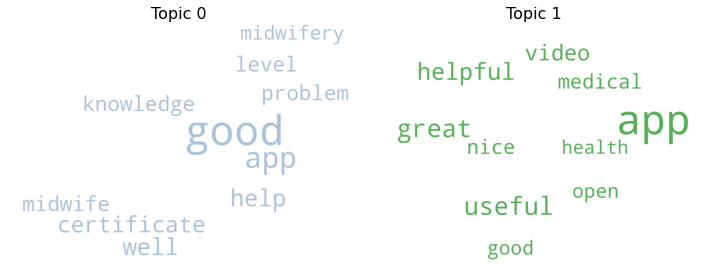

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap="inferno",
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

we will look into recent_review to divide poistive and negative.
Positive and negative divide based on score (1,2 = negative / 4,5 = positive)

In [ ]:
# look into socre  1,2
df_latest_less3 = df_latest[df_latest['score']<3]
df_latest_less3.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,tokens
1,29c64f19-2a5e-4e35-b4de-f92eb05c0c6e,Parishmita Baruah,https://play-lh.googleusercontent.com/a-/AD5-W...,quizzes opening,2,0,3.5.3,2022-12-07 18:14:26,None,NaT,[quiz]
2,55ef6527-6ff6-4a0c-a553-34ae6108e437,S S,https://play-lh.googleusercontent.com/a-/AD5-W...,open exam help,1,0,3.5.2,2022-11-11 14:55:14,None,NaT,"[open, exam, help]"


In [ ]:
df_latest_less3.shape

(22, 11)

In [ ]:
df_latest_less3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 1 to 228
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              36 non-null     object        
 1   userName              36 non-null     object        
 2   userImage             36 non-null     object        
 3   content               36 non-null     object        
 4   score                 36 non-null     int64         
 5   thumbsUpCount         36 non-null     int64         
 6   reviewCreatedVersion  28 non-null     object        
 7   at                    36 non-null     datetime64[ns]
 8   replyContent          9 non-null      object        
 9   repliedAt             9 non-null      datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 3.1+ KB


In [ ]:
print(22/115)

0.19130434782608696


In [ ]:
# look into socre >= 4
df_latest_ge3= df_latest[df_latest['score']>3]
df_latest_ge3.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,tokens
0,12580b98-500c-44a0-a447-698800fec6b2,MARTIN KAHELLA,https://play-lh.googleusercontent.com/a/AEdFTp...,👍,5,0,3.5.3,2022-12-08 07:21:21,None,NaT,[]
3,ba9bdccd-7758-48ca-9677-d6c36f6ccd05,Hafsa Anju,https://play-lh.googleusercontent.com/a/AEdFTp...,Good apps,5,0,None,2022-11-03 05:31:28,None,NaT,"[good, app]"


In [ ]:
df_latest_ge3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 0 to 114
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              85 non-null     object        
 1   userName              85 non-null     object        
 2   userImage             85 non-null     object        
 3   content               85 non-null     object        
 4   score                 85 non-null     int64         
 5   thumbsUpCount         85 non-null     int64         
 6   reviewCreatedVersion  62 non-null     object        
 7   at                    85 non-null     datetime64[ns]
 8   replyContent          27 non-null     object        
 9   repliedAt             27 non-null     datetime64[ns]
 10  tokens                85 non-null     object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 8.0+ KB


In [ ]:
df_latest_ge3.shape

(85, 11)

In [ ]:
print(85/115)

0.7391304347826086


In [ ]:
# 0 means negative
df_latest_less3['rating'] = 0
# 1 means positive
df_latest_ge3['rating'] = 1

<ipython-input-119-de284ec4362a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_latest_less3['rating'] = 0
<ipython-input-119-de284ec4362a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_latest_ge3['rating'] = 1


In [ ]:
#df = pd.concat([df_less3, df_ge3])

In [ ]:
df_latest_less3.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,tokens,rating
1,29c64f19-2a5e-4e35-b4de-f92eb05c0c6e,Parishmita Baruah,https://play-lh.googleusercontent.com/a-/AD5-W...,The quizzes are not opening,2,0,3.5.3,2022-12-07 18:14:26,None,NaT,[quiz],0
2,55ef6527-6ff6-4a0c-a553-34ae6108e437,S S,https://play-lh.googleusercontent.com/a-/AD5-W...,I can't open the exam ...why . Please help,1,0,3.5.2,2022-11-11 14:55:14,None,NaT,[exam],0
7,a36dc925-04cb-434b-8281-07420c377347,Ibad Khan,https://play-lh.googleusercontent.com/a/AEdFTp...,Wst of time not open app,1,0,3.4.8,2022-07-29 13:44:26,None,NaT,"[wst, time, app]",0
10,ca025b89-1392-492a-ae30-e3d37d086ba3,Rania Siddig,https://play-lh.googleusercontent.com/a-/AD5-W...,App installed but didn't work,1,1,None,2022-05-16 20:19:01,None,NaT,[app],0
16,37f8a946-d1cf-4501-82cc-babca3fa39b4,Maleeha Butt,https://play-lh.googleusercontent.com/a-/AD5-W...,I can't download any language plz fix it,1,2,3.4.6,2022-02-15 14:11:11,"Sorry for the inconvenience, Could you please ...",2022-02-22 09:19:50,[language],0


In [ ]:
df_latest_ge3.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,tokens,rating
0,12580b98-500c-44a0-a447-698800fec6b2,MARTIN KAHELLA,https://play-lh.googleusercontent.com/a/AEdFTp...,👍,5,0,3.5.3,2022-12-08 07:21:21,None,NaT,[],1
3,ba9bdccd-7758-48ca-9677-d6c36f6ccd05,Hafsa Anju,https://play-lh.googleusercontent.com/a/AEdFTp...,Good apps,5,0,None,2022-11-03 05:31:28,None,NaT,"[good, app]",1
4,e1ad7b31-cd05-4ca3-a87f-b1ccde3f776f,Abubakar Seidu,https://play-lh.googleusercontent.com/a/AEdFTp...,This is the best app for management of deliver...,5,0,3.4.8,2022-10-20 10:14:21,None,NaT,"[good, app, management, delivery, easy]",1
6,16c53b7e-12cb-4d39-81e7-de36a31bc44f,Thadeus Makwanda,https://play-lh.googleusercontent.com/a-/AD5-W...,Cute,5,0,None,2022-08-01 08:13:17,None,NaT,[],1
8,fd19a299-3ba0-4f75-9a69-7fc0812870ab,Veenubala Joshi,https://play-lh.googleusercontent.com/a/AEdFTp...,This is more interesting app to learn and prac...,5,1,3.3.4,2022-06-24 03:39:31,None,NaT,"[interesting, app]",1


In [ ]:
# negative topic
# Create a Dictionary from the text_clean(tokens)
dictionary1= Dictionary(df_latest_less3['tokens'])
# filter out low-frequency / high-frequency data
# dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=1000)
# construct corpus using this dictionary
corpus1 = [dictionary1.doc2bow(doc) for doc in df_latest_less3['tokens']]

In [ ]:
corpus1

In [ ]:
# Training the model
lda_model1 = LdaMulticore(corpus1, id2word=dictionary1, num_topics=2, workers = 4, passes=10, random_state=10)

In [ ]:
lda_model1.print_topics()

[(0,
  '0.052*"level" + 0.052*"mark" + 0.052*"answer" + 0.037*"quiz" + 0.037*"good" + 0.022*"repeatedly" + 0.022*"highly" + 0.022*"set" + 0.022*"❌" + 0.022*"knowledge"'),
 (1,
  '0.105*"app" + 0.040*"bad" + 0.039*"video" + 0.024*"feedback" + 0.024*"complition" + 0.024*"step" + 0.024*"stop" + 0.024*"previous" + 0.024*"pop" + 0.024*"suddenly"')]

In [ ]:
# Let's try to visualize
lda_display1 = pyLDAvis.gensim_models.prepare(lda_model1, corpus1, dictionary1)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [ ]:
# Let's Visualize, Explore the distribution of these label VS topics
pyLDAvis.display(lda_display1)

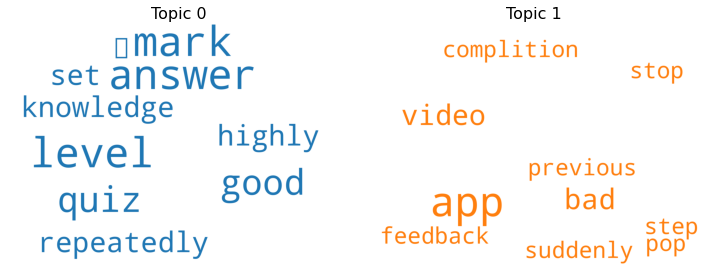

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics1 = lda_model1.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics1[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
!pip install git+https://github.com/rwalk/gsdmm.git
from gsdmm import MovieGroupProcess

cluster_word_distribution = gsdmm.cluster_word_distribution
wordcloud = WordCloud(background_color='white', 
                            width=1800,
                            height=700,
                            colormap='Greys').generate_from_frequencies(cluster_word_distribution[0])
                            fig, ax = plt.subplots(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");


In [ ]:
# positive topic

# Create a Dictionary from the text_clean(tokens)
dictionary2 = Dictionary(df_latest_ge3['tokens'])
# filter out low-frequency / high-frequency data
# dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=1000)
# construct corpus using this dictionary
corpus2 = [dictionary2.doc2bow(doc) for doc in df_latest_ge3['tokens']]

In [ ]:
corpus2

In [ ]:
# Training the model
lda_model2 = LdaMulticore(corpus2, id2word=dictionary2, num_topics=2, workers = 4, passes=10, random_state=10)

In [ ]:
lda_model2.print_topics()

[(0,
  '0.136*"app" + 0.081*"good" + 0.030*"great" + 0.028*"useful" + 0.025*"helpful" + 0.022*"medical" + 0.018*"delivery" + 0.018*"midwife" + 0.018*"midwifery" + 0.018*"interesting"'),
 (1,
  '0.032*"important" + 0.025*"problem" + 0.021*"helpful" + 0.020*"certificate" + 0.018*"knowledge" + 0.018*"network" + 0.018*"aap" + 0.018*"informative" + 0.018*"work" + 0.017*"baby"')]

In [ ]:
# Let's try to visualize
lda_display2 = pyLDAvis.gensim_models.prepare(lda_model2, corpus2, dictionary2)

In [ ]:
# Let's Visualize, Explore the distribution of these label VS topics
pyLDAvis.display(lda_display2)

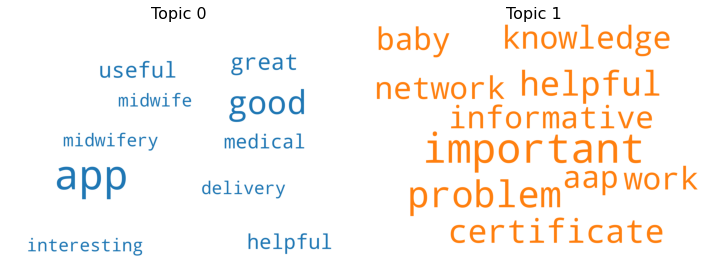

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics2 = lda_model2.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics2[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
!pip install git+https://github.com/rwalk/gsdmm.git
from gsdmm import MovieGroupProcess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-4c1hv06k
  Running command git clone -q https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-4c1hv06k


In [ ]:
reviews = reviews_all('dk.maternity.safedelivery')

In [ ]:
df = pd.DataFrame(np.array(reviews),columns=['review'])


In [ ]:
df = df.join(pd.DataFrame(df.pop('review').tolist()))

In [ ]:
def text_prepro(texts):
  
  texts_clean = texts.map(lambda t: prepro.clean(t))
  texts_clean = texts_clean.str.replace('#','')

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [ ]:
df['content'] = text_prepro(df['content'].apply(str))

  0%|          | 1/240 [00:00<00:40,  5.87it/s]/usr/local/lib/python3.8/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 240/240 [00:00<00:00, 950.62it/s]


In [ ]:
from datetime import datetime

In [ ]:
df = df[(df['at'] > '2020-01-01')]

In [ ]:
tokens = []

for summary in nlp.pipe(df['content'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV','VEB'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [ ]:
df['tokens'] = tokens

In [ ]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,tokens
0,12580b98-500c-44a0-a447-698800fec6b2,MARTIN KAHELLA,https://play-lh.googleusercontent.com/a/AEdFTp...,,5,0,3.5.3,2022-12-08 07:21:21,None,NaT,[]
1,29c64f19-2a5e-4e35-b4de-f92eb05c0c6e,Parishmita Baruah,https://play-lh.googleusercontent.com/a-/AD5-W...,quizzes opening,2,0,3.5.3,2022-12-07 18:14:26,None,NaT,[quiz]
2,55ef6527-6ff6-4a0c-a553-34ae6108e437,S S,https://play-lh.googleusercontent.com/a-/AD5-W...,open exam help,1,0,3.5.2,2022-11-11 14:55:14,None,NaT,"[open, exam, help]"
3,ba9bdccd-7758-48ca-9677-d6c36f6ccd05,Hafsa Anju,https://play-lh.googleusercontent.com/a/AEdFTp...,good apps,5,0,None,2022-11-03 05:31:28,None,NaT,"[good, app]"
4,e1ad7b31-cd05-4ca3-a87f-b1ccde3f776f,Abubakar Seidu,https://play-lh.googleusercontent.com/a/AEdFTp...,best app management delivery easy use,5,0,3.4.8,2022-10-20 10:14:21,None,NaT,"[good, app, management, delivery, easy, use]"


In [ ]:
dictionary = Dictionary(df['tokens'])

In [ ]:
dictionary.filter_extremes(no_below=5, no_above=0.5,keep_n = None)

In [ ]:
vocab_length = len(dictionary)

In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

In [ ]:
gsdmm = MovieGroupProcess(K=2, alpha=0.1, beta=0.5, n_iters=15)

In [ ]:
y = gsdmm.fit(df['tokens'].to_numpy(), vocab_length)

In stage 0: transferred 46 clusters with 2 clusters populated
In stage 1: transferred 26 clusters with 2 clusters populated
In stage 2: transferred 28 clusters with 2 clusters populated
In stage 3: transferred 27 clusters with 2 clusters populated
In stage 4: transferred 32 clusters with 2 clusters populated
In stage 5: transferred 23 clusters with 2 clusters populated
In stage 6: transferred 22 clusters with 2 clusters populated
In stage 7: transferred 23 clusters with 2 clusters populated
In stage 8: transferred 31 clusters with 2 clusters populated
In stage 9: transferred 24 clusters with 2 clusters populated
In stage 10: transferred 23 clusters with 2 clusters populated
In stage 11: transferred 25 clusters with 2 clusters populated
In stage 12: transferred 28 clusters with 2 clusters populated
In stage 13: transferred 33 clusters with 2 clusters populated
In stage 14: transferred 32 clusters with 2 clusters populated


In [ ]:
doc_count = np.array(gsdmm.cluster_doc_count)

In [ ]:
top_index = doc_count.argsort()[-15:][::-1]

In [ ]:
top_index

array([0, 1])

In [ ]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))

In [ ]:
top_words(gsdmm.cluster_word_distribution, top_index, 20)



Cluster 0 : [('app', 34), ('good', 20), ('great', 8), ('helpful', 7), ('useful', 6), ('nice', 5), ('medical', 5), ('interesting', 4), ('educative', 4), ('video', 4), ('student', 4), ('midwifery', 4), ('bad', 3), ('health', 3), ('delivery', 3), ('excellent', 3), ('midwife', 3), ('worker', 2), ('important', 2), ('knowledge', 2)]

Cluster 1 : [('app', 13), ('well', 4), ('open', 4), ('time', 4), ('knowledge', 3), ('feedback', 3), ('certificate', 3), ('level', 3), ('problem', 3), ('baby', 2), ('maternity', 2), ('help', 2), ('quiz', 2), ('informative', 2), ('good', 2), ('answer', 2), ('error', 2), ('work', 2), ('video', 2), ('mark', 2)]


In [ ]:
cluster_word_distribution = gsdmm.cluster_word_distribution

In [ ]:
cluster_word_distribution

In [ ]:
cluster_word_distribution = gsdmm.cluster_word_distribution

In [ ]:
wordcloud = WordCloud(background_color='white', 
                            width=1800,
                            height=700,
                            colormap='Greys').generate_from_frequencies(cluster_word_distribution[0])

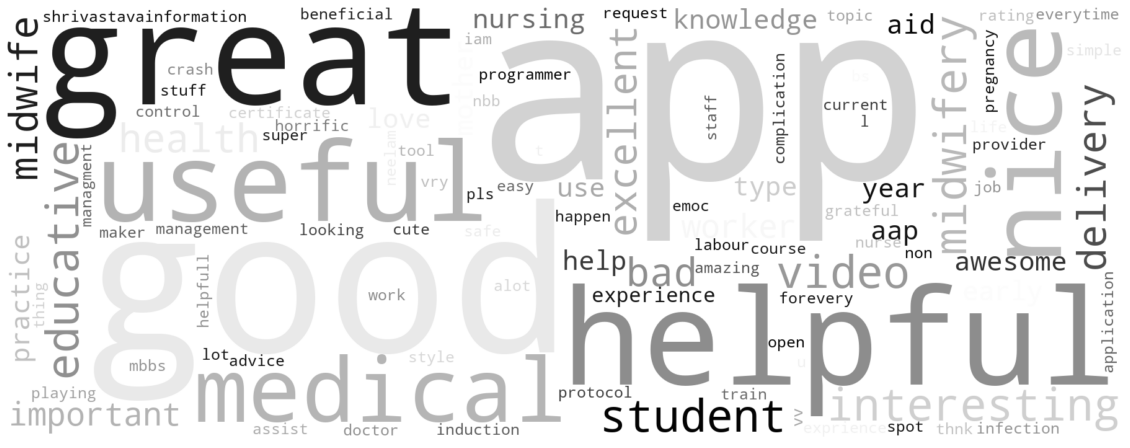

In [ ]:
fig, ax = plt.subplots(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");


In [ ]:
wordcloud = WordCloud(background_color='white', 
                            width=1800,
                            height=700,
                            colormap='Greys').generate_from_frequencies(cluster_word_distribution[1])

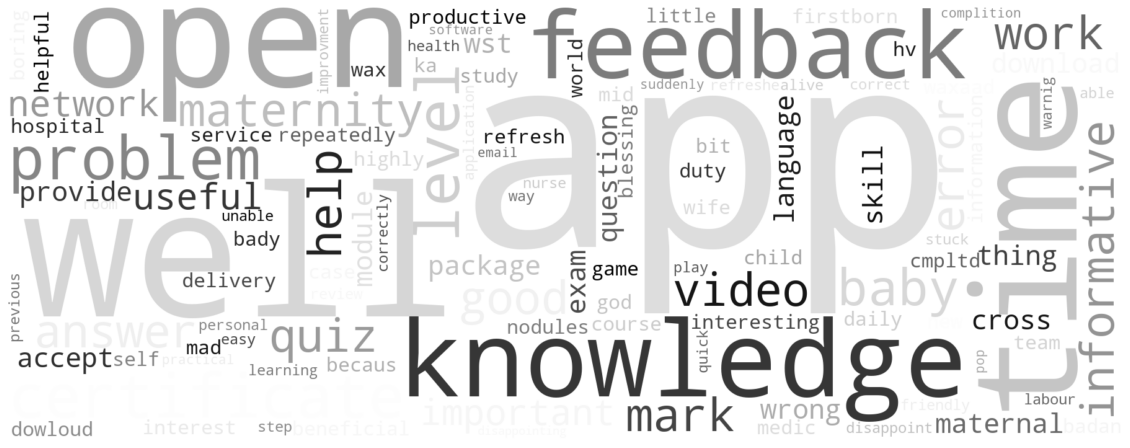

In [ ]:
fig, ax = plt.subplots(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

In [ ]:
dictionary1= Dictionary(df_latest_less3['tokens'])

In [ ]:
dictionary1.filter_extremes(no_below=5, no_above=0.6,keep_n = None)

In [ ]:
vocab_length = len(dictionary1)

In [ ]:
corpus1 = [dictionary1.doc2bow(doc) for doc in df_latest_less3['tokens']]

In [ ]:
gsdmm = MovieGroupProcess(K=1, alpha=0.1, beta=0.5, n_iters=15)

In [ ]:
y = gsdmm.fit(df_latest_less3['tokens'].to_numpy(), vocab_length)

In [ ]:
# number of documents per topic
doc_count = np.array(gsdmm.cluster_doc_count)
# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]

# define function to get top words per topic
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        
# get top words in topics
top_words(gsdmm.cluster_word_distribution, top_index, 20)


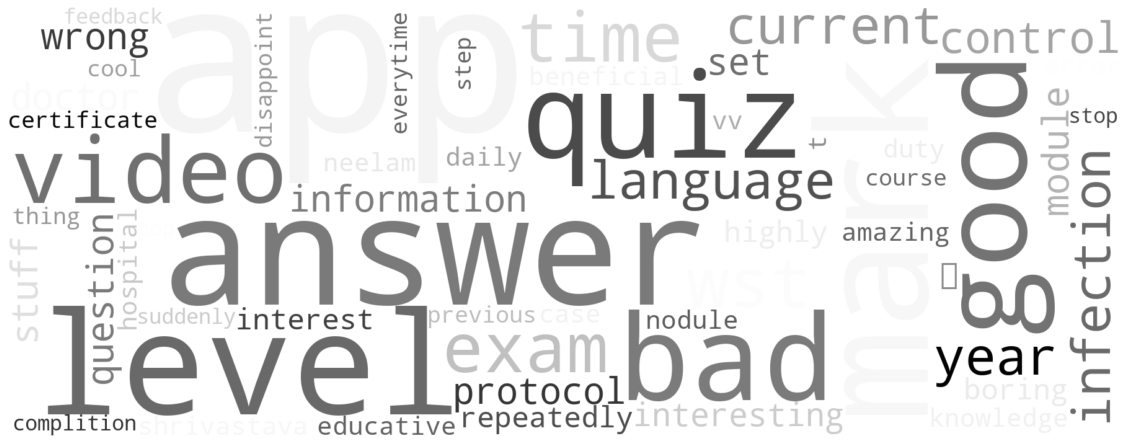

In [ ]:
cluster_word_distribution = gsdmm.cluster_word_distribution


# Generate a word cloud image
wordcloud = WordCloud(background_color='white', 
                            width=1800,
                            height=700,
                            colormap='Greys').generate_from_frequencies(cluster_word_distribution[0])

# Print to screen
fig, ax = plt.subplots(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");
